# 🚀 Notebook : Modélisation – Prédiction des flux colis

## 📦 Objectif
Prédire le **nombre de colis entrants** pour les centres de tri en utilisant les données météo et temporelles.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

os.environ["LOKY_MAX_CPU_COUNT"] = "4"

import joblib  # Pour sauvegarder le modèle

In [2]:
# Pour la démo, on part du fichier CSV
df = pd.read_csv("../data/processed/merged_data.csv")
df.head()

date  centre_id  nb_colis_entree  nb_colis_sortie  volume_moyen  \
0  2023-01-01          1              730              645          1.29   
1  2023-01-02          1             1016              914          1.41   
2  2023-01-03          1             1045              951          1.97   
3  2023-01-04          1             1025              899          2.15   
4  2023-01-05          1              941              853          3.53   

   temperature_max  temperature_min  precipitation  windspeed_max  is_holiday  \
0             15.5             12.0            2.0           30.5           1   
1             15.5              6.9            7.4           29.2           0   
2              9.9              5.8            1.0           26.3           0   
3             13.2              9.6            3.4           28.9           0   
4             13.8             11.4            0.4           24.5           0   

   day_of_week  month  day_of_month  is_weekend  
0            6      1             1           1  
1            0      1             2           0  
2            1      1             3           0  
3            2      1             4           0  
4            3      1             5           0

In [3]:
# Target : nombre de colis entrants
target = "nb_colis_entree"

# Features : on enlève la target et la colonne 'date'
# ⚠️ On retire aussi 'nb_colis_sortie' car on suppose qu'elle n'est pas connue au moment de la prédiction
features = df.drop(columns=["date", "nb_colis_entree", "nb_colis_sortie"])

X = features
y = df[target]

In [4]:
# Séparation train/test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

In [5]:
# Normalisation des données
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Sauvegarde du scaler pour l’utilisation future
joblib.dump(scaler, "../models/scaler.pkl")

['../models/scaler.pkl']

In [6]:
# Fonction d'évaluation des modèles
def evaluate_model(y_true, y_pred, model_name="Modèle"):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2 = r2_score(y_true, y_pred)
    print(f"{model_name} → RMSE: {rmse:.2f}, R²: {r2:.2f}")
    return rmse, r2

## 📦Test des modèles
- Random Forest
- Linear Regression (baseline)
- XGBoost
- LightGBM

In [7]:
# Random Forest (baseline)
from sklearn.ensemble import RandomForestRegressor

model_rf = RandomForestRegressor(n_estimators=100, max_depth=10, random_state=42, n_jobs=-1)
model_rf.fit(X_train_scaled, y_train)
y_pred_rf = model_rf.predict(X_test_scaled)
rmse_rf, r2_rf = evaluate_model(y_test, y_pred_rf, "Random Forest")

Random Forest → RMSE: 50.67, R²: 0.94


In [8]:
# Linear Regression
from sklearn.linear_model import LinearRegression

model_lr = LinearRegression()
model_lr.fit(X_train_scaled, y_train)
y_pred_lr = model_lr.predict(X_test_scaled)
rmse_lr, r2_lr = evaluate_model(y_test, y_pred_lr, "Linear Regression")

Linear Regression → RMSE: 96.13, R²: 0.77


In [9]:
# XGBoost
from xgboost import XGBRegressor

model_xgb = XGBRegressor(n_estimators=100, max_depth=5, random_state=42)
model_xgb.fit(X_train_scaled, y_train)
y_pred_xgb = model_xgb.predict(X_test_scaled)
rmse_xgb, r2_xgb = evaluate_model(y_test, y_pred_xgb, "XGBoost")

XGBoost → RMSE: 53.65, R²: 0.93


In [10]:
# lightgbm
from lightgbm import LGBMRegressor

model_lgbm = LGBMRegressor(n_estimators=100, max_depth=15, min_split_gain=0.001, random_state=42)
model_lgbm.fit(X_train_scaled, y_train)
X_test_df = pd.DataFrame(X_test_scaled, columns=X_test.columns)
y_pred_lgbm = model_lgbm.predict(X_test_df)
rmse_lgbm, r2_lgbm = evaluate_model(y_test, y_pred_lgbm, "LightGBM")

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000316 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1132
[LightGBM] [Info] Number of data points in the train set: 2924, number of used features: 11
[LightGBM] [Info] Start training from score 960.535568
LightGBM → RMSE: 50.25, R²: 0.94


## 📊 Visualisation des performances

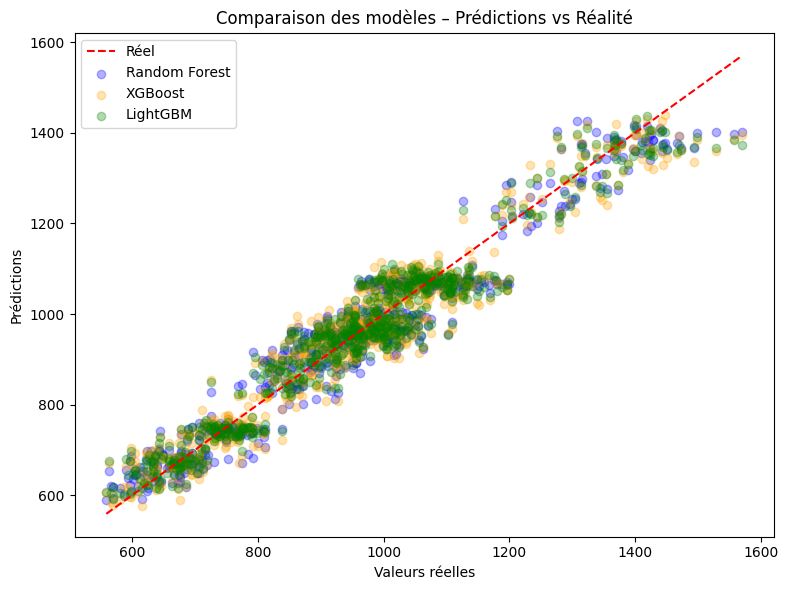

In [11]:
plt.figure(figsize=(8, 6))
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], "r--", label="Réel")

plt.scatter(y_test, y_pred_rf, alpha=0.3, label="Random Forest", color="blue")
plt.scatter(y_test, y_pred_xgb, alpha=0.3, label="XGBoost", color="orange")
plt.scatter(y_test, y_pred_lgbm, alpha=0.3, label="LightGBM", color="green")

plt.xlabel("Valeurs réelles")
plt.ylabel("Prédictions")
plt.title("Comparaison des modèles – Prédictions vs Réalité")
plt.legend()
plt.tight_layout()
plt.show()

# 📋 Tableau comparatif final

In [12]:
results = pd.DataFrame({
    "Modèle": ["Random Forest", "Linear Regression", "XGBoost", "LightGBM"],
    "RMSE": [rmse_rf, rmse_lr, rmse_xgb, rmse_lgbm],
    "R²": [r2_rf, r2_lr, r2_xgb, r2_lgbm]
})
results.sort_values("RMSE")

Modèle       RMSE        R²
3           LightGBM  50.251044  0.938407
0      Random Forest  50.666562  0.937385
2            XGBoost  53.645513  0.929805
1  Linear Regression  96.133769  0.774581

## Interprétation
✅ 1. Random Forest vs LightGBM
- Les deux modèles sont très proches en performance, avec un léger avantage pour LightGBM :

    - RMSE plus bas (meilleure précision globale)

    - R² plus élevé (meilleure capacité explicative)

- LightGBM est souvent plus rapide à l’entraînement, ce qui est un plus pour de futurs tests de scalabilité (sur gros volumes).

❌ 2. Linear Regression (baseline)
- Performances nettement moins bonnes :

    - RMSE presque 2 fois plus élevé

    - R² bien inférieur (seulement 77 % de variance expliquée)

- 👉 Cela confirme que le problème est non linéaire → les modèles d’ensemble sont bien plus adaptés.

⚖️ 3. XGBoost
- Performances honorables mais légèrement moins bonnes que RF et LGBM.

- Peut encore s’améliorer avec un tuning fin (ex : learning rate, subsample…).

### Conclusion
🎯 LightGBM est le meilleur candidat.

Il offre :

- Une meilleure précision

- Une vitesse d’entraînement optimisée

- Une très bonne généralisabilité

# 🔧 Optimisation des hyperparamètres – LightGBM

In [13]:
from sklearn.model_selection import GridSearchCV
from lightgbm import LGBMRegressor

# Grille simple pour démarrer (tu peux l'élargir ensuite)
param_grid = {
    'n_estimators': [100, 300],
    'max_depth': [10, 15],
    'learning_rate': [0.05, 0.1],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}

# Modèle de base
model_base = LGBMRegressor(random_state=42)

# GridSearchCV
grid_search = GridSearchCV(
    estimator=model_base,
    param_grid=param_grid,
    scoring='neg_root_mean_squared_error',
    cv=3,
    n_jobs=-1,
    verbose=1
)

# Lancement
grid_search.fit(X_train_scaled, y_train)

# Affichage
print("✅ Meilleurs paramètres :", grid_search.best_params_)
print("📉 RMSE (val croisée) :", -grid_search.best_score_)

Fitting 3 folds for each of 32 candidates, totalling 96 fits
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000605 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1132
[LightGBM] [Info] Number of data points in the train set: 2924, number of used features: 11
[LightGBM] [Info] Start training from score 960.535568
✅ Meilleurs paramètres : {'colsample_bytree': 1.0, 'learning_rate': 0.05, 'max_depth': 15, 'n_estimators': 100, 'subsample': 0.8}
📉 RMSE (val croisée) : 52.02981996288372


In [14]:
# Réentraînement du modèle optimisé
best_params = grid_search.best_params_
model_optimized = LGBMRegressor(**best_params, random_state=42)
model_optimized.fit(X_train_scaled, y_train)

X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test.columns)
# Évaluation
y_pred_optimized = model_optimized.predict(X_test_scaled)
rmse_opt, r2_opt = evaluate_model(y_test, y_pred_optimized, "LightGBM optimisé")

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000216 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1132
[LightGBM] [Info] Number of data points in the train set: 2924, number of used features: 11
[LightGBM] [Info] Start training from score 960.535568
LightGBM optimisé → RMSE: 49.40, R²: 0.94


## ✅ Interprétation
- On a gagné ≈ 0.85 point de RMSE, ce qui est significatif pour une prédiction quotidienne de volumes.

- Le R² reste stable à 0.94, donc le modèle reste très explicatif.

- Le tuning nous a permis de mieux ajuster sans overfitting.

## ✅ Sauvegarde du modèle optimisé

In [16]:
joblib.dump(model_optimized, "../models/lightgbm_model_optimized.pkl")
print("✅ Modèle optimisé sauvegardé dans ../models/lightgbm_model_optimized.pkl")

✅ Modèle optimisé sauvegardé dans ../models/lightgbm_model_optimized.pkl
